## 1. Load libraries

In [47]:
import pandas as pd
from datetime import date
import seaborn as sns
import numpy as np
from itertools import product
from xgboost import XGBRegressor

## 2. Load dataset 

In [2]:
sales = pd.read_csv("data/sales_train.csv")

In [3]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
sales.shape

(2935849, 6)

In [5]:
test_df = pd.read_csv("data/test.csv").set_index("ID")

In [6]:
test_df.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [7]:
test_df.shape

(214200, 2)

In [8]:
shops = pd.read_csv("data/shops.csv")

In [9]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
shops.shape

(60, 2)

In [11]:
items = pd.read_csv("data/items.csv")

In [12]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [13]:
items.shape

(22170, 3)

In [14]:
item_cats = pd.read_csv("data/item_categories.csv")

In [15]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [16]:
item_cats.shape

(84, 2)

## 3. Data Preprocessing

In [17]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [18]:
sales["date"] = pd.to_datetime(sales["date"], format="%d.%m.%Y")

In [19]:
sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [20]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


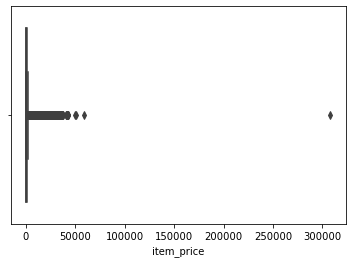

In [21]:
ax = sns.boxplot(x = sales["item_price"])

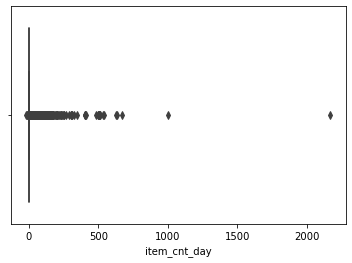

In [22]:
ax = sns.boxplot(x = sales["item_cnt_day"])

For outliers, we remove items with price > 100000 and sales > 1001.

In [23]:
sales = sales[sales["item_price"] < 100000]
sales = sales[sales["item_cnt_day"] < 1001]

There is one item with price below zero, so we replace its price with median.

In [24]:
sales[sales["item_price"] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [25]:
sales.loc[sales["item_price"] < 0, "item_price"] = sales[
    (sales["shop_id"] == 32)
    & (sales["item_id"] == 2973)
    & (sales["date_block_num"] == 4)
    & (sales["item_price"] > 0)
]["item_price"].median()

## 4. Feature Engineering

In [26]:
features = []

In [27]:
cols = ["date_block_num", "shop_id", "item_id"]

for i in range(34):
    sale = sales[sales["date_block_num"] == i]
    features.append(
        np.array(list(product([i], sale["shop_id"].unique(), sale["item_id"].unique())))
    )

features = pd.DataFrame(np.vstack(features), columns=cols)
features.sort_values(cols, inplace=True)
features.head()

,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32


In [28]:
sales["revenue"] = sales["item_price"] * sales["item_cnt_day"]

In [29]:
group = sales.groupby(["date_block_num", "shop_id", "item_id"]).agg(
    {"item_cnt_day": ["sum"]}
)
group.columns = ["item_cnt_month"]
group.reset_index(inplace=True)

features = pd.merge(features, group, on=cols, how="left")
features.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,NaN
1,0,0,27,NaN
2,0,0,28,NaN
3,0,0,29,NaN
4,0,0,32,6.0


In [30]:
features["item_cnt_month"] = features["item_cnt_month"].fillna(0).clip(0,20)

In [31]:
test_df["date_block_num"] = 34

In [32]:
features = pd.concat([features, test_df], ignore_index=True, sort=False, keys=cols)
features.fillna(0, inplace=True)
features.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0


In [33]:
features = pd.merge(features, shops, on=["shop_id"], how="left")
features = pd.merge(features, items, on=["item_id"], how="left")
features = pd.merge(features, item_cats, on=["item_category_id"], how="left")
features.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_name,item_name,item_category_id,item_category_name
0,0,0,19,0.0,"!Якутск Орджоникидзе, 56 фран",/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD
1,0,0,27,0.0,"!Якутск Орджоникидзе, 56 фран","007 Legends [PS3, русская версия]",19,Игры - PS3
2,0,0,28,0.0,"!Якутск Орджоникидзе, 56 фран","007 Legends [PС, Jewel, русская версия]",30,Игры PC - Стандартные издания
3,0,0,29,0.0,"!Якутск Орджоникидзе, 56 фран","007 Legends [Xbox 360, русская версия]",23,Игры - XBOX 360
4,0,0,32,6.0,"!Якутск Орджоникидзе, 56 фран",1+1,40,Кино - DVD


In [34]:
def lag_feature(df, lags, col):
    tmp = df[["date_block_num", "shop_id", "item_id", col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = [
            "date_block_num",
            "shop_id",
            "item_id",
            col + "_lag_" + str(i),
        ]
        shifted["date_block_num"] += i
        df = pd.merge(
            df, shifted, on=["date_block_num", "shop_id", "item_id"], how="left"
        )
    return df

In [35]:
features = lag_feature(features, [1, 2, 3, 6, 12], "item_cnt_month")
features.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_name,item_name,item_category_id,item_category_name,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,0,19,0.0,"!Якутск Орджоникидзе, 56 фран",/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,Кино - DVD,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,"!Якутск Орджоникидзе, 56 фран","007 Legends [PS3, русская версия]",19,Игры - PS3,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,"!Якутск Орджоникидзе, 56 фран","007 Legends [PС, Jewel, русская версия]",30,Игры PC - Стандартные издания,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,"!Якутск Орджоникидзе, 56 фран","007 Legends [Xbox 360, русская версия]",23,Игры - XBOX 360,NaN,NaN,NaN,NaN,NaN
4,0,0,32,6.0,"!Якутск Орджоникидзе, 56 фран",1+1,40,Кино - DVD,NaN,NaN,NaN,NaN,NaN


### Mean Encodings

In [36]:
group = features.groupby(["date_block_num"]).agg({"item_cnt_month": ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace=True)
features = pd.merge(features, group, on=["date_block_num"], how="left")

features = lag_feature(features, [1], "date_avg_item_cnt")
features.drop(["date_avg_item_cnt"], axis=1, inplace=True)

In [37]:
group = features.groupby(["date_block_num", "item_id"]).agg(
    {"item_cnt_month": ["mean"]}
)
group.columns = ["date_item_avg_item_cnt"]
group.reset_index(inplace=True)

features = pd.merge(features, group, on=["date_block_num", "item_id"], how="left")
features = lag_feature(features, [1, 2, 3, 6, 12], "date_item_avg_item_cnt")
features.drop(["date_item_avg_item_cnt"], axis=1, inplace=True)

In [38]:
group = features.groupby(["date_block_num", "shop_id"]).agg(
    {"item_cnt_month": ["mean"]}
)
group.columns = ["date_shop_avg_item_cnt"]
group.reset_index(inplace=True)

features = pd.merge(features, group, on=["date_block_num", "shop_id"], how="left")
features = lag_feature(features, [1, 2, 3, 6, 12], "date_shop_avg_item_cnt")
features.drop(["date_shop_avg_item_cnt"], axis=1, inplace=True)

In [39]:
group = features.groupby(["date_block_num", "item_category_id"]).agg(
    {"item_cnt_month": ["mean"]}
)
group.columns = ["date_cat_avg_item_cnt"]
group.reset_index(inplace=True)

features = pd.merge(features, group, on=["date_block_num", "item_category_id"], how="left")
features = lag_feature(features, [1], "date_cat_avg_item_cnt")
features.drop(["date_cat_avg_item_cnt"], axis=1, inplace=True)

In [40]:
group = features.groupby(["date_block_num", "shop_id", "item_category_id"]).agg(
    {"item_cnt_month": ["mean"]}
)
group.columns = ["date_shop_cat_avg_item_cnt"]
group.reset_index(inplace=True)

features = pd.merge(
    features, group, on=["date_block_num", "shop_id", "item_category_id"], how="left"
)
features = lag_feature(features, [1], "date_shop_cat_avg_item_cnt")
features.drop(["date_shop_cat_avg_item_cnt"], axis=1, inplace=True)

In [41]:
features['month'] = features['date_block_num'] % 12

In [42]:
days = pd.Series([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
features["days"] = features["month"].map(days)

In [43]:
features.tail()

,date_block_num,shop_id,item_id,item_cnt_month,shop_name,item_name,item_category_id,item_category_name,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_item_avg_item_cnt_lag_12,date_shop_avg_item_cnt_lag_1,date_shop_avg_item_cnt_lag_2,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,month,days
11127999,34,45,18454,0.0,"Самара ТЦ ""ПаркХаус""",СБ. Союз 55,55,Музыка - CD локального производства,1.0,0.0,...,NaN,0.126732,0.12881,0.138998,0.137611,NaN,0.196845,0.126866,10,30
11128000,34,45,16188,0.0,"Самара ТЦ ""ПаркХаус""",Настольная игра Нано Кёрлинг,64,Подарки - Настольные игры,0.0,0.0,...,NaN,0.126732,0.12881,NaN,NaN,NaN,0.155870,0.094488,10,30
11128001,34,45,15757,0.0,"Самара ТЦ ""ПаркХаус""",НОВИКОВ АЛЕКСАНДР Новая коллекция,55,Музыка - CD локального производства,0.0,0.0,...,0.18,0.126732,0.12881,0.138998,0.137611,0.181272,0.196845,0.126866,10,30
11128002,34,45,19648,0.0,"Самара ТЦ ""ПаркХаус""",ТЕРЕМ - ТЕРЕМОК сб.м/ф (Регион),40,Кино - DVD,0.0,0.0,...,NaN,0.126732,0.12881,0.138998,0.137611,NaN,0.220812,0.083756,10,30
11128003,34,45,969,0.0,"Самара ТЦ ""ПаркХаус""",3 ДНЯ НА УБИЙСТВО (BD),37,Кино - Blu-Ray,0.0,0.0,...,0.12,0.126732,0.12881,0.138998,0.137611,0.181272,0.256864,0.128205,10,30


In [44]:
features.to_pickle("data/data.pkl")

## 5.Build Models

In [52]:
data = pd.read_pickle("data/data.pkl")
data = data.drop(columns = ["shop_name", "item_name", "item_category_name"])

In [53]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [54]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[15:26:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.10478	validation_1-rmse:1.05734
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.03011	validation_1-rmse:1.00544
[2]	validation_0-rmse:0.99124	validation_1-rmse:0.97858
[3]	validation_0-rmse:0.96371	validation_1-rmse:0.95725
[4]	validation_0-rmse:0.94886	validation_1-rmse:0.94930
[5]	validation_0-rmse:0.93955	validation_1-rmse:0.94488
[6]	validation_0-rmse:0.93322	validation_1-rmse:0.94302
[7]	validation_0-rmse:0.92964	validation_1-rmse:0.94236
[8]	validation_0-rmse:0.92647	validation_1-rmse:0.94069
[9]	validation_0-rmse:0.92425	validation_1-rmse:0.93946
[10]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [56]:
y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({"ID": test_df.index, "item_cnt_month": y_test})
submission.to_csv("data/submission.csv", index=False)